# Canadian Tech Job salary prediction
This notebook aims to analyse the dataset of Canadian salary information derived from the Stack Overflow surveys which spans from 2011 to 2023. And use this data to train machine learning model to predict salary based on factors like City, experience etc.

Dataset can be found at [Kaggle](https://www.kaggle.com/datasets/moun12345/canadian-salary-data-from-stack-overflow-survey/data)

In [1]:
# Lets install necessary Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

In [2]:
!pip install catboost

In [3]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# EDA and Data Processing

In [4]:
df = pd.read_csv('CanadaData.csv') #loading the data

In [5]:
df.head(4) #looking at the top 4

,Year,Company Size,Industry,Experience,Title,Country,Salary (USD),City
0,2023,10 to 19 employees,"Information Services, IT, Software Development...",5 to 9 years,Data scientist or machine learning specialist,Canada,52046.0,Halifax
1,2023,100 to 499 employees,"Manufacturing, Transportation, or Supply Chain",10 or more years,"Developer, full-stack",Canada,64686.0,Montreal
2,2023,20 to 99 employees,"Information Services, IT, Software Development...",2 to 4 years,"Developer, full-stack",Canada,59481.0,Hamilton–Niagara Peninsula
3,2023,20 to 99 employees,"Manufacturing, Transportation, or Supply Chain",5 to 9 years,Data or business analyst,Canada,63199.0,Halifax


In [6]:
df.duplicated().sum()

470

- There are 470 duplicated entries

In [7]:
# Lets drop the duplicates
df = df.drop_duplicates()
df.duplicated().sum()

0

Let's look at the data distribution across the years

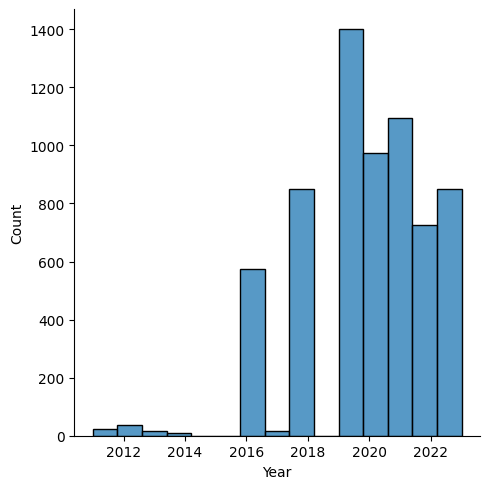

In [8]:
# Lets look at the data distribution for each year
sns.displot(df['Year'],bins = 15)

- In our analysis, we observed that the dataset exhibits imbalances and inconsistencies, particularly concerning data from years prior to the last 5 years. To ensure the accuracy and reliability of our salary predictions, we have decided to focus on the most recent 5 years of data. This period is more relevant for our predictions as it reflects the most current trends and market conditions.

In [9]:
latest_5_years = df['Year'].drop_duplicates().nlargest(5) #Getting the latest 5 years
df_latest = df[df['Year'].isin(latest_5_years)]
df_latest['Year'].unique()

array([2023, 2022, 2021, 2020, 2019])

In [10]:
df_latest.notnull().sum()

,0
Year,5043
Company Size,5043
Industry,5043
Experience,5043
Title,5043
Country,5043
Salary (USD),5043
City,5043


In [11]:
df_latest.head(4)

,Year,Company Size,Industry,Experience,Title,Country,Salary (USD),City
0,2023,10 to 19 employees,"Information Services, IT, Software Development...",5 to 9 years,Data scientist or machine learning specialist,Canada,52046.0,Halifax
1,2023,100 to 499 employees,"Manufacturing, Transportation, or Supply Chain",10 or more years,"Developer, full-stack",Canada,64686.0,Montreal
2,2023,20 to 99 employees,"Information Services, IT, Software Development...",2 to 4 years,"Developer, full-stack",Canada,59481.0,Hamilton–Niagara Peninsula
3,2023,20 to 99 employees,"Manufacturing, Transportation, or Supply Chain",5 to 9 years,Data or business analyst,Canada,63199.0,Halifax


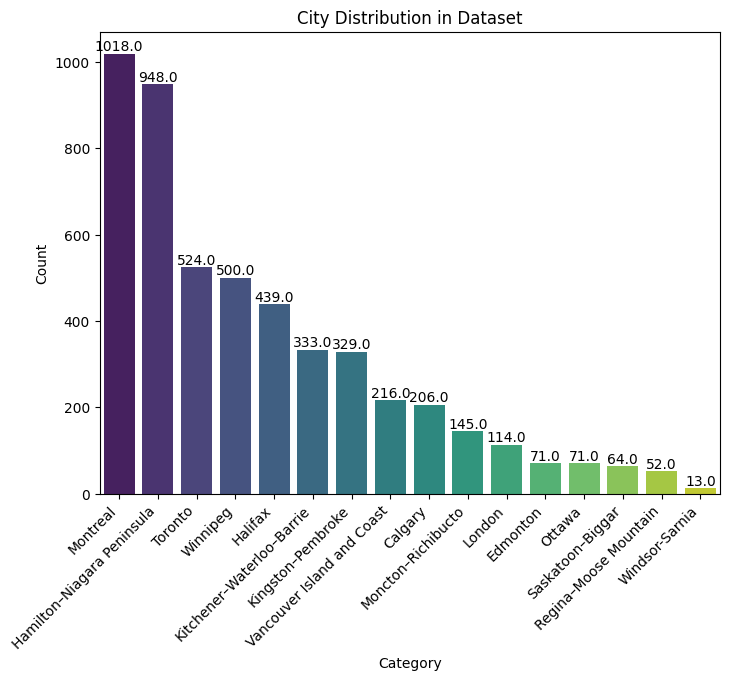

In [12]:
city_counts = df_latest['City'].value_counts()

# Plotting the bar chart
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=city_counts.index, y=city_counts.values, palette='viridis')
for bars in ax.patches:
  height = bars.get_height()
  ax.annotate(f'{height}', (bars.get_x() + bars.get_width() / 2, height),
                ha='center', va='bottom')

plt.xlabel('Category')
plt.xticks(rotation=45, ha='right')  # Rotate labels 45 degrees, align right
plt.ylabel('Count')
plt.title('City Distribution in Dataset')
plt.show()



- Lets replace cities with less than 70 data points as "other"

In [13]:
cities_to_replace = city_counts[city_counts < 70].index
df_latest['City'] = df_latest['City'].replace(cities_to_replace, 'Other')
df_latest['City'].unique()

array(['Halifax', 'Montreal', 'Hamilton–Niagara Peninsula',
       'Kitchener–Waterloo–Barrie', 'Toronto',
       'Vancouver Island and Coast', 'Moncton–Richibucto', 'Calgary',
       'Winnipeg', 'Kingston–Pembroke', 'Edmonton', 'Ottawa', 'Other',
       'London'], dtype=object)

In [14]:
df_latest['Industry'].replace('Information Services, IT, Software Development, or other Technology', 'IT / Software', inplace=True)

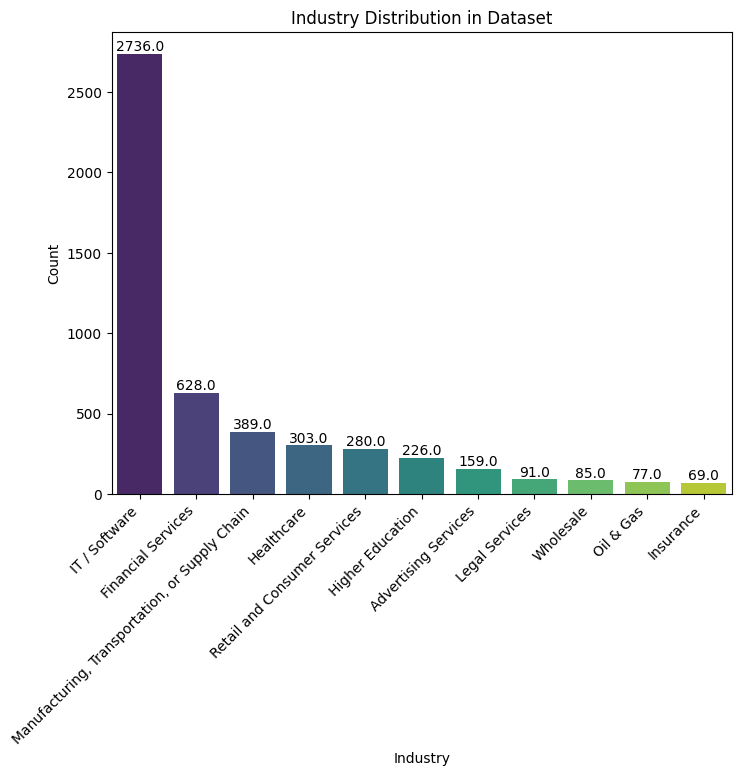

In [15]:
Industry_counts = df_latest['Industry'].value_counts()

# Plotting the bar chart
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=Industry_counts.index, y=Industry_counts.values, palette='viridis')
for bars in ax.patches:
  height = bars.get_height()
  ax.annotate(f'{height}', (bars.get_x() + bars.get_width() / 2, height),
                ha='center', va='bottom')

plt.xticks(rotation=45, ha='right')  # Rotate labels 45 degrees, align right
plt.ylabel('Count')
plt.title('Industry Distribution in Dataset')
plt.show()

- It is important to note that the majority of our dataset is sourced from the IT sector. This sector constitutes a significant portion of the data, which may impact the overall distribution and analysis results. When interpreting findings or making predictions, please consider that the high representation of IT-related data could influence trends and insights specific to this industry.

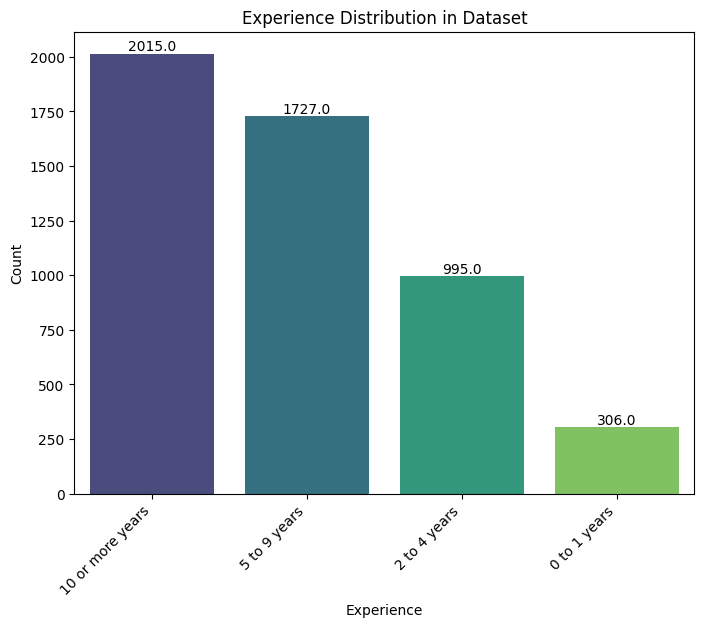

In [16]:
Experience = df_latest['Experience'].value_counts()

# Plotting the bar chart
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=Experience.index, y=Experience.values, palette='viridis')
for bars in ax.patches:
  height = bars.get_height()
  ax.annotate(f'{height}', (bars.get_x() + bars.get_width() / 2, height),
                ha='center', va='bottom')

plt.xticks(rotation=45, ha='right')  # Rotate labels 45 degrees, align right
plt.ylabel('Count')
plt.title('Experience Distribution in Dataset')
plt.show()

- Please note that "0 to 1 year" category is underrepresented, which could affect the reliability of any insights or predictions related to entry-level roles.

In [17]:
df_latest['Title'].value_counts()

,count
Title,
"Developer, full-stack",1553
"Developer, back-end",977
"Developer, front-end",498
"Developer, desktop or enterprise applications",370
"Developer, mobile",218
DevOps specialist,200
"Developer, embedded applications or devices",128
Data scientist or machine learning specialist,104
"Developer, game or graphics",102


In [18]:
df_latest['Company Size'].value_counts()


,count
Company Size,
100 to 499 employees,1148
20 to 99 employees,1133
"10,000 or more employees",648
"1,000 to 4,999 employees",577
10 to 19 employees,536
2 to 9 employees,388
500 to 999 employees,361
"5,000 to 9,999 employees",252


- Let's group company sizes into few categories

In [19]:
category_mapping = {
    '2 to 9 employees': 'Small (2-19 Employees)',
    '10 to 19 employees': 'Small (2-19 Employees)',
    '20 to 99 employees': 'Medium (20-499 Employees)',
    '100 to 499 employees': 'Medium (20-499 Employees)',
    '500 to 999 employees': 'Large (500-9999 Employees)',
    '1,000 to 4,999 employees': 'Large (500-9999 Employees)',
    '5,000 to 9,999 employees': 'Large (500-9999 Employees)',
    '10,000 or more employees': 'Very Large (10000 or More Employees'
}

In [20]:
df_latest['Company Size'] = df_latest['Company Size'].replace(category_mapping)

In [21]:
df_latest['Company Size'].value_counts()

,count
Company Size,
Medium (20-499 Employees),2281
Large (500-9999 Employees),1190
Small (2-19 Employees),924
Very Large (10000 or More Employees,648


In [22]:
# Converting USD to CAD at 1.37 Exchange rate
df_latest['Salary (CAD)'] = df_latest['Salary (USD)'] * 1.37
df_latest.drop('Salary (USD)',axis = 1,inplace = True)
df_latest.head()

,Year,Company Size,Industry,Experience,Title,Country,City,Salary (CAD)
0,2023,Small (2-19 Employees),IT / Software,5 to 9 years,Data scientist or machine learning specialist,Canada,Halifax,71303.02
1,2023,Medium (20-499 Employees),"Manufacturing, Transportation, or Supply Chain",10 or more years,"Developer, full-stack",Canada,Montreal,88619.82
2,2023,Medium (20-499 Employees),IT / Software,2 to 4 years,"Developer, full-stack",Canada,Hamilton–Niagara Peninsula,81488.97
3,2023,Medium (20-499 Employees),"Manufacturing, Transportation, or Supply Chain",5 to 9 years,Data or business analyst,Canada,Halifax,86582.63
4,2023,Medium (20-499 Employees),IT / Software,5 to 9 years,"Developer, front-end",Canada,Montreal,73340.21


- In our analysis, we have decided to exclude the "Year" column from the dataset. This decision is based on the rationale that predicting salaries based on specific years is not desired. Instead, we are focusing on salary data from the past 5 years, as we believe this time frame provides the most relevant and current insights for salary predictions

In [23]:
cols_todrop = ['Year', 'Country'] # Dropping country as well since it's same for all the data
df_latest.drop(cols_todrop, axis = 1, inplace = True)
df_latest.head()

,Company Size,Industry,Experience,Title,City,Salary (CAD)
0,Small (2-19 Employees),IT / Software,5 to 9 years,Data scientist or machine learning specialist,Halifax,71303.02
1,Medium (20-499 Employees),"Manufacturing, Transportation, or Supply Chain",10 or more years,"Developer, full-stack",Montreal,88619.82
2,Medium (20-499 Employees),IT / Software,2 to 4 years,"Developer, full-stack",Hamilton–Niagara Peninsula,81488.97
3,Medium (20-499 Employees),"Manufacturing, Transportation, or Supply Chain",5 to 9 years,Data or business analyst,Halifax,86582.63
4,Medium (20-499 Employees),IT / Software,5 to 9 years,"Developer, front-end",Montreal,73340.21


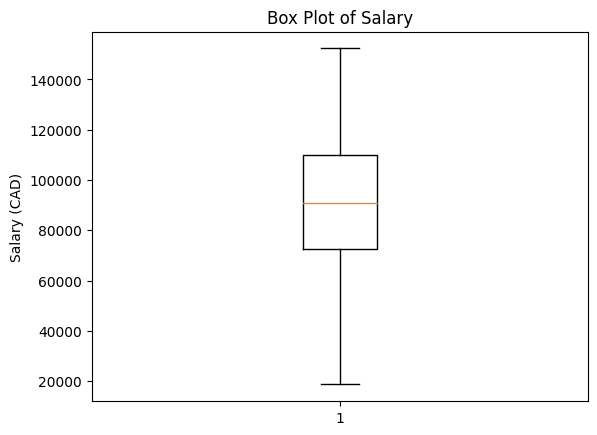

In [24]:
# Checking for outliers in the salary
plt.boxplot(df_latest['Salary (CAD)'])
plt.ylabel('Salary (CAD)')
plt.title('Box Plot of Salary')
plt.show()

- The box plots reveals that there are no outliers present in the dataset

In [25]:
df_latest.head(4)

,Company Size,Industry,Experience,Title,City,Salary (CAD)
0,Small (2-19 Employees),IT / Software,5 to 9 years,Data scientist or machine learning specialist,Halifax,71303.02
1,Medium (20-499 Employees),"Manufacturing, Transportation, or Supply Chain",10 or more years,"Developer, full-stack",Montreal,88619.82
2,Medium (20-499 Employees),IT / Software,2 to 4 years,"Developer, full-stack",Hamilton–Niagara Peninsula,81488.97
3,Medium (20-499 Employees),"Manufacturing, Transportation, or Supply Chain",5 to 9 years,Data or business analyst,Halifax,86582.63


In [26]:
cols = ['City','Company Size', 'Experience','Title','Industry']

In [27]:
y = df_latest['Salary (CAD)'].values.reshape(-1,)
X = df_latest.drop('Salary (CAD)',axis = 1)


## Training Catboost Regressor

In [28]:
cat_cols = df_latest.select_dtypes(include=['object']).columns
cat_cols_idx = [list(X.columns).index(c) for c in cat_cols]
cat_cols_idx

[0, 1, 2, 3, 4]

In [30]:
X.shape

(5043, 5)

In [32]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=0, stratify=df_latest['City'])
stratify_temp = df_latest.loc[X_temp.index, 'City']

X_test, X_eval, y_test, y_eval = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0, stratify=stratify_temp)

# Print the shapes of the training and testing sets to verify the split
print("Training set shapes - X_train: {}, y_train: {}".format(X_train.shape, y_train.shape))
print("Testing set shapes - X_test: {}, y_test: {}".format(X_test.shape, y_test.shape))
print("Eval set shapes - X_eval: {}, y_eval: {}".format(X_eval.shape, y_eval.shape))

Training set shapes - X_train: (4034, 5), y_train: (4034,)
Testing set shapes - X_test: (504, 5), y_test: (504,)
Eval set shapes - X_eval: (505, 5), y_eval: (505,)


In [33]:
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, RegressorMixin

class CatBoostRegressorWithPool(BaseEstimator, RegressorMixin):
    def __init__(self, **params):
        self.model = CatBoostRegressor(**params)
        self.cat_features = params.get('cat_features', None)

    def fit(self, X, y):
        train_pool = Pool(data=X, label=y, cat_features=self.cat_features)
        self.model.fit(train_pool)
        return self

    def predict(self, X):
        return self.model.predict(X)

    def set_params(self, **params):
        self.model.set_params(**params)
        return self

    def get_params(self, deep=True):
        return self.model.get_params(deep=deep)

#Define the parameter grid
param_grid = {
    'depth': [6, 8],
    'learning_rate': [0.008],
    'l2_leaf_reg': [1,3,5,10],
    'iterations': [3000,4000]
}
# param_grid = {
#     'depth': [8],
#     'learning_rate': [0.008],
#     'iterations': [4000]
# }

# Initialize the custom wrapper with categorical features
model = CatBoostRegressorWithPool(cat_features=[0, 1, 2, 3, 4])

# Use GridSearchCV with the custom wrapper
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


Streaming output truncated to the last 5000 lines.
3002:	learn: 7451.1212260	total: 23.3s	remaining: 7.73s
3003:	learn: 7450.8095832	total: 23.3s	remaining: 7.72s
3004:	learn: 7449.7791897	total: 23.3s	remaining: 7.71s
3005:	learn: 7448.9765498	total: 23.3s	remaining: 7.71s
3006:	learn: 7448.2060643	total: 23.3s	remaining: 7.7s
3007:	learn: 7447.5285785	total: 23.3s	remaining: 7.69s
3008:	learn: 7446.8035052	total: 23.3s	remaining: 7.68s
3009:	learn: 7446.6276552	total: 23.3s	remaining: 7.67s
3010:	learn: 7446.1840912	total: 23.3s	remaining: 7.67s
3011:	learn: 7445.8277813	total: 23.4s	remaining: 7.66s
3012:	learn: 7445.5462942	total: 23.4s	remaining: 7.65s
3013:	learn: 7444.5113208	total: 23.4s	remaining: 7.64s
3014:	learn: 7444.0112777	total: 23.4s	remaining: 7.63s
3015:	learn: 7443.4898553	total: 23.4s	remaining: 7.63s
3016:	learn: 7443.4591333	total: 23.4s	remaining: 7.62s
3017:	learn: 7442.8986057	total: 23.4s	remaining: 7.61s
3018:	learn: 7442.8086165	total: 23.4s	remaining: 7.61

In [36]:
eval_set = Pool(X_eval, y_eval,cat_features=cat_cols_idx)

In [39]:
best_model = CatBoostRegressor(**grid_search.best_params_, cat_features=[0, 1, 2, 3, 4], verbose=1, early_stopping_rounds=100)
best_model.fit(X_train, y_train, eval_set=eval_set, use_best_model=True, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 26124.4024694	test: 24923.3404790	best: 24923.3404790 (0)	total: 33.7ms	remaining: 2m 14s
1:	learn: 25986.0184748	test: 24779.0201628	best: 24779.0201628 (1)	total: 53.4ms	remaining: 1m 46s
2:	learn: 25850.8765313	test: 24631.6880016	best: 24631.6880016 (2)	total: 90.2ms	remaining: 2m
3:	learn: 25698.5781283	test: 24476.7094474	best: 24476.7094474 (3)	total: 104ms	remaining: 1m 44s
4:	learn: 25554.6915250	test: 24329.4495206	best: 24329.4495206 (4)	total: 122ms	remaining: 1m 37s
5:	learn: 25409.2392061	test: 24182.8753195	best: 24182.8753195 (5)	total: 138ms	remaining: 1m 31s
6:	learn: 25268.2361648	test: 24040.6141875	best: 24040.6141875 (6)	total: 147ms	remaining: 1m 24s
7:	learn: 25141.4723649	test: 23905.3527684	best: 23905.3527684 (7)	total: 163ms	remaining: 1m 21s
8:	learn: 25011.0805236	test: 23765.5985981	best: 23765.5985981 (8)	total: 172ms	remaining: 1m 16s
9:	learn: 24894.2916483	test: 23634.4873820	best: 23634.4873820 (9)	total: 182ms	remaining: 1m 12s
10:	learn: 

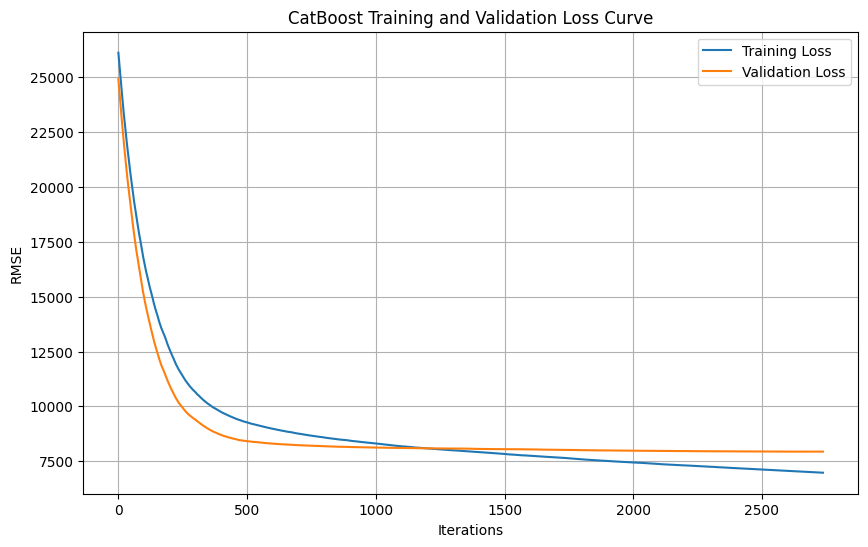

In [40]:
eval_results = best_model.get_evals_result()

# Plot the loss curve
plt.figure(figsize=(10, 6))
plt.plot(eval_results['learn']['RMSE'], label='Training Loss')
plt.plot(eval_results['validation']['RMSE'], label='Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('CatBoost Training and Validation Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

In [44]:
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)
y_eval_pred = best_model.predict(X_eval)

In [45]:
rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
rmse_eval = mean_squared_error(y_eval, y_eval_pred, squared=False)

In [46]:
print(f"RMSE score for train {round(rmse_train)} kUSD/year, and for test {round(rmse_test)} kUSD/year, and for eval {round(rmse_eval)}")

RMSE score for train 7820 kUSD/year, and for test 8483 kUSD/year, and for eval 7935


In [47]:
print(r2_score(y_test, y_test_pred)*100)
print(r2_score(y_train, y_train_pred)*100)

89.00316906528367
91.13421050037661


## Neural Network


In [48]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
X_encoded = encoder.fit_transform(X)

print(X_encoded)

[[0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [56]:
encoder = OneHotEncoder(sparse=False, drop='first')
X_train_encoded = encoder.fit_transform(X_train)
X_eval_encoded = encoder.transform(X_eval)
X_test_encoded = encoder.transform(X_test)

In [63]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.regularizers import l2
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=100)

model = Sequential()
model.add(Dense(64, input_dim=X_train_encoded.shape[1], activation='relu'))
model.add(Dense(32, activation='relu',  kernel_regularizer=l2(0.01)))
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train_encoded, y_train, validation_data= (X_eval_encoded, y_eval), epochs=2000, batch_size=32, verbose = 1, callbacks=[early_stopping])

Epoch 1/2000
127/127 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 9110636544.0000 - val_loss: 8862125056.0000
Epoch 2/2000
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9030339584.0000 - val_loss: 8753793024.0000
Epoch 3/2000
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8893478912.0000 - val_loss: 8442636288.0000
Epoch 4/2000
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8459350016.0000 - val_loss: 7858918400.0000
Epoch 5/2000
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7788239360.0000 - val_loss: 6986452480.0000
Epoch 6/2000
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6862631936.0000 - val_loss: 5872998400.0000
Epoch 7/2000
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5849138176.0000 - val_loss: 4621803520.0000
Epoch 8/2000
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4411614720.0000 - val_loss: 3385905152.0000
Epoch 9/2000
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3306749184.0000 - val_loss: 2315732736.0000
Epoch 10/2000
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s

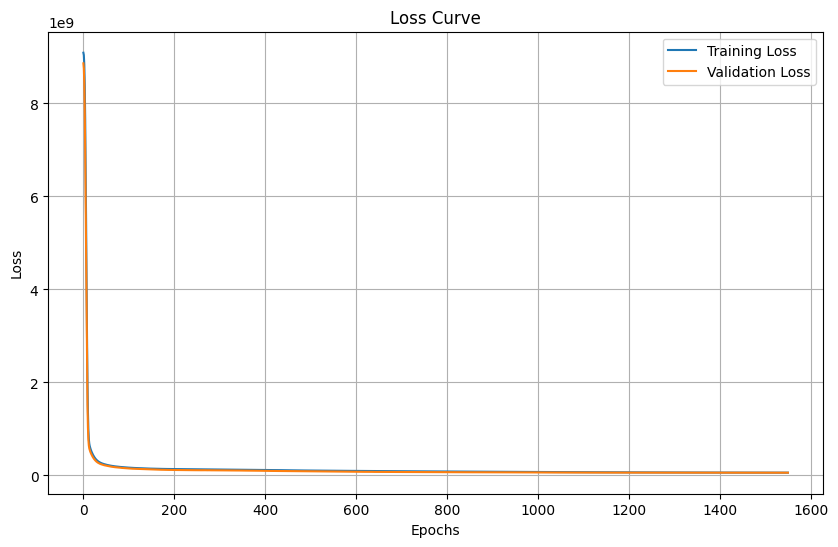

In [64]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Plot the loss values
plt.figure(figsize=(10, 6))
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

- Test

In [65]:
y_train_pred2 = model.predict(X_train_encoded)
y_test_pred2 = model.predict(X_test_encoded)
y_eval_pred2 = model.predict(X_eval_encoded)

127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [66]:
rmse_train = mean_squared_error(y_train, y_train_pred2, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred2, squared=False)
rmse_eval = mean_squared_error(y_eval, y_eval_pred2, squared=False)

In [67]:
print(f"RMSE score for train {round(rmse_train)} kUSD/year, and for test {round(rmse_test)} kUSD/year, and for eval {round(rmse_eval)}")

RMSE score for train 7730 kUSD/year, and for test 8569 kUSD/year, and for eval 7664


In [69]:
print(r2_score(y_test, y_test_pred2)*100)
print(r2_score(y_train, y_train_pred2)*100)

88.78019785430897
91.33599689253921


- Since both models gave similar performance, I chose the CatBoost model for deployment to ensure efficiency in terms of speed and resource usage. And as the dataset is small, the model's performace is limited.

# Interpreting Catboost Model

In [73]:
feature_importances = best_model.get_feature_importance(Pool(X_train, y_train, cat_features=cat_cols_idx))
feature_names = X_train.columns
for feature, importance in zip(feature_names, feature_importances):
    print(f"Feature: {feature}, Importance: {importance}")


Feature: Company Size, Importance: 3.1125124008583605
Feature: Industry, Importance: 0.9924261716935181
Feature: Experience, Importance: 33.75721287914074
Feature: Title, Importance: 9.134030445128541
Feature: City, Importance: 53.00381810317887


In [75]:
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df_sorted = importance_df.sort_values(by='Importance', ascending=False)
importance_df_sorted.head()

,Feature,Importance
4,City,53.003818
2,Experience,33.757213
3,Title,9.134030
0,Company Size,3.112512
1,Industry,0.992426


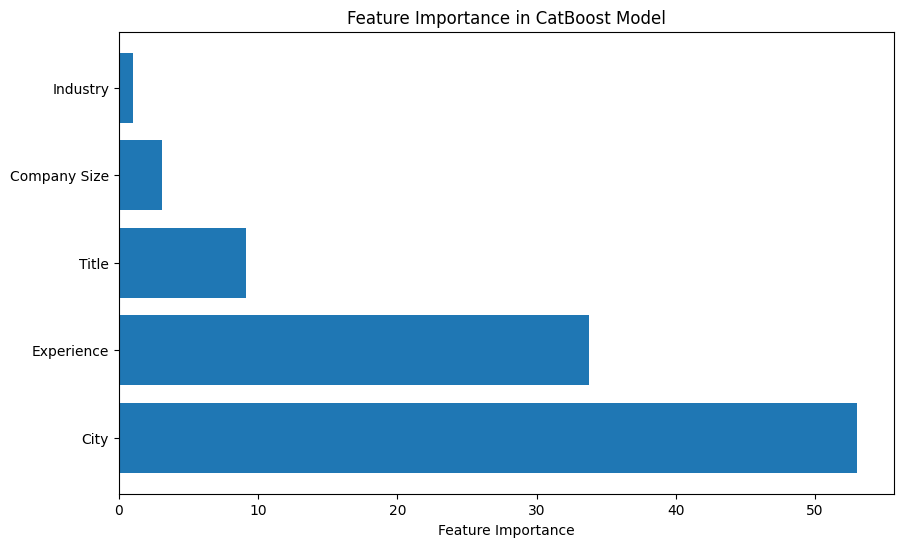

In [77]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(importance_df_sorted['Feature'], importance_df_sorted['Importance'])
plt.xlabel("Feature Importance")
plt.title("Feature Importance in CatBoost Model")
plt.show()

- Since City has the highest importance score, it means that the location is a major factor in determining salaries given same title followed by expirence.

# Saving the Catboost Model



In [78]:
import joblib

# Save the model
joblib.dump(best_model, 'salary_prediction_model.pkl')

['salary_prediction_model.pkl']